<a href="https://colab.research.google.com/github/nhjung-phd/TimeSeriesAnalysis/blob/main/notebooks/26_prophet_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prophet 기반 테슬라(TSLA) 주가 예측

🛠️ 1. 라이브러리 불러오기 & 환경 준비

In [ ]:
# (Colab/로컬 공통) 필요한 패키지 설치
# !pip install -q prophet yfinance plotly

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12,5)


📊 2. 테슬라(TSLA) 주가 데이터 다운로드 및 시각화

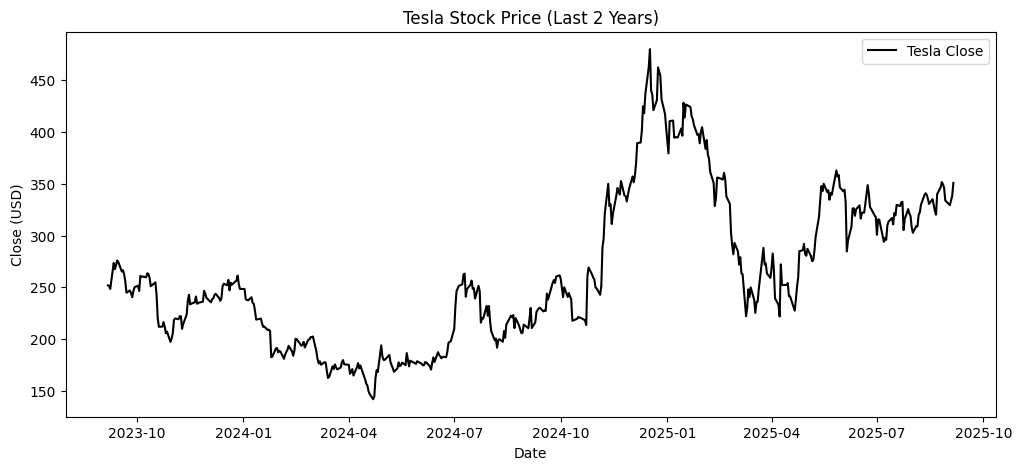

In [3]:
import yfinance as yf
import pandas as pd

# 1) TSLA 다운로드 - 컬럼을 단일 레벨로 강제(group_by='column')
df = yf.download(
    "TSLA",
    period="2y",
    interval="1d",
    group_by="column",   # <- 중요: 컬럼을 Open/High/Low/Close 단일 레벨로
    auto_adjust=False,
    actions=False,
    progress=False,
)

# 2) 방어 코드: 빈 DF면 중단
if df is None or df.empty:
    raise RuntimeError("yfinance가 빈 데이터를 반환했습니다. 네트워크/기간/인터벌을 확인하세요.")

# 3) 혹시라도 MultiIndex가 남아있으면 평탄화
if isinstance(df.columns, pd.MultiIndex):
    df.columns = ["_".join([str(c) for c in col if c]) for col in df.columns]

# 4) Close 컬럼 확보 (예: 'TSLA_Close' 같은 이름도 커버)
close_candidates = [c for c in df.columns if c.lower().endswith("close")]
if not close_candidates:
    # 대안 경로: Ticker API 사용
    alt = yf.Ticker("TSLA").history(period="2y", interval="1d")
    if alt is None or alt.empty or "Close" not in alt.columns:
        raise KeyError(f"'Close' 컬럼을 찾지 못했습니다. 현재 컬럼: {list(df.columns)}")
    df = alt.copy()
    close_col = "Close"
else:
    close_col = close_candidates[0]

# 5) 최종 표준화: 반드시 'Close' 단일 컬럼을 보장
df = df.rename(columns={close_col: "Close"})
df = df[["Close"]].dropna().copy()
df.index = pd.to_datetime(df.index).tz_localize(None)  # Prophet 호환용 tz 제거

# (선택) 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(df.index, df["Close"], label="Tesla Close", color="black")
plt.title("Tesla Stock Price (Last 2 Years)")
plt.xlabel("Date"); plt.ylabel("Close (USD)")
plt.legend(); plt.show()


🔄 3. Prophet 입력형식 변환 & (선택) 로그변환

In [4]:
use_log = True  # 로그변환 사용할지 여부

data = df[["Close"]].copy()
if use_log:
    data["y"] = np.log1p(data["Close"])
else:
    data["y"] = data["Close"]
data["ds"] = data.index.tz_localize(None)  # Prophet은 tz-naive 선호

# Train/Test split (최근 20영업일 테스트)
test_horizon = 20
train = data.iloc[:-test_horizon].copy()
test  = data.iloc[-test_horizon:].copy()
print(train.tail(2), "\n---\n", test.head(2))


                 Close         y         ds
Date                                       
2025-08-06  319.910004  5.771161 2025-08-06
2025-08-07  322.269989  5.778488 2025-08-07 
---
                  Close         y         ds
Date                                       
2025-08-08  329.649994  5.801060 2025-08-08
2025-08-11  339.029999  5.829034 2025-08-11


🧠 4. Prophet 모델 구성

In [5]:
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.1,
    seasonality_mode="additive"  # 주가 로그스케일이라 additive가 보통 안정적
)
m.add_country_holidays(country_name='US')

# (선택) 추가 계절성 예시: 월별 효과
# m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# 학습
m.fit(train[["ds","y"]])


DEBUG:cmdstanpy:input tempfile: /tmp/tmpk5z28wf5/3_jwx6q1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk5z28wf5/da3zjsh7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50814', 'data', 'file=/tmp/tmpk5z28wf5/3_jwx6q1.json', 'init=/tmp/tmpk5z28wf5/da3zjsh7.json', 'output', 'file=/tmp/tmpk5z28wf5/prophet_modelxoba9x06/prophet_model-20250908130011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:00:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


🧪 5. 백테스트형 검증 (Prophet 내장 CV)

In [6]:
# 데이터 길이에 따라 초기 학습 길이/주기 자동 설정 (간단 로직)
n = len(train)
initial_days = int(n * 0.7)
period_days  = max(int((n - initial_days) / 3), 5)

df_cv = cross_validation(
    m,
    initial=f"{initial_days} days",
    period=f"{period_days} days",
    horizon=f"{test_horizon} days",
    parallel="processes"
)
df_p = performance_metrics(df_cv, rolling_window=1)
df_p[["horizon","mape","rmse","mae"]].head()


INFO:prophet:Making 8 forecasts with cutoffs between 2024-08-16 00:00:00 and 2025-07-18 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7aeb73759c40>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk5z28wf5/8yn4da0m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk5z28wf5/1i6j66vl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk5z28wf5/2nr2i60z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpk5z28wf5/tpv5b8a5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50741', 'data', 'file=/tmp/tmpk5z28wf5/8yn4da0m.json', 'init=/tmp/tmpk5z28wf5/tpv5b8a5.json', 'output', 'file=/tmp/tmpk5z28wf5/prophet_modelwftp8ovk/prophet_model-20250908130012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
DEBUG:cmdstanpy:running CmdStan, num_threads: None
13:00:12 - cmdstanpy - INFO -

,horizon,mape,rmse,mae
0,20 days,0.029255,0.19889,0.165048


🏁 6. 테스트 구간 예측 & 성능 평가

MAE : 18.928335432659367
RMSE: 22.610485661201142
MAPE: 5.60%


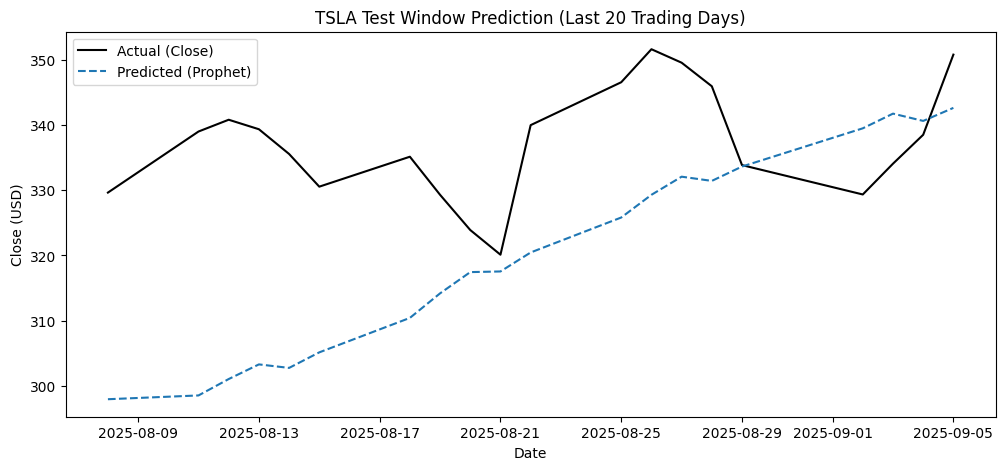

In [8]:
# 테스트 구간 예측
future_test = test[["ds"]].copy()
forecast_test = m.predict(future_test)

# 역변환
if use_log:
    y_true = np.expm1(test["y"].values)
    y_pred = np.expm1(forecast_test["yhat"].values)
else:
    y_true = test["y"].values
    y_pred = forecast_test["yhat"].values

def mape(a, f):
    return np.mean(np.abs((a - f) / a)) * 100

mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print("MAE :", mean_absolute_error(y_true, y_pred))
print("RMSE:", rmse)
print("MAPE: %.2f%%" % mape(y_true, y_pred))

# 시각화
plt.plot(test["ds"], y_true, label="Actual (Close)", color="black")
plt.plot(test["ds"], y_pred, label="Predicted (Prophet)", linestyle="--")
plt.title("TSLA Test Window Prediction (Last 20 Trading Days)")
plt.xlabel("Date"); plt.ylabel("Close (USD)")
plt.legend(); plt.show()


🔮 7. 향후 30영업일 예측 & 전체 플롯

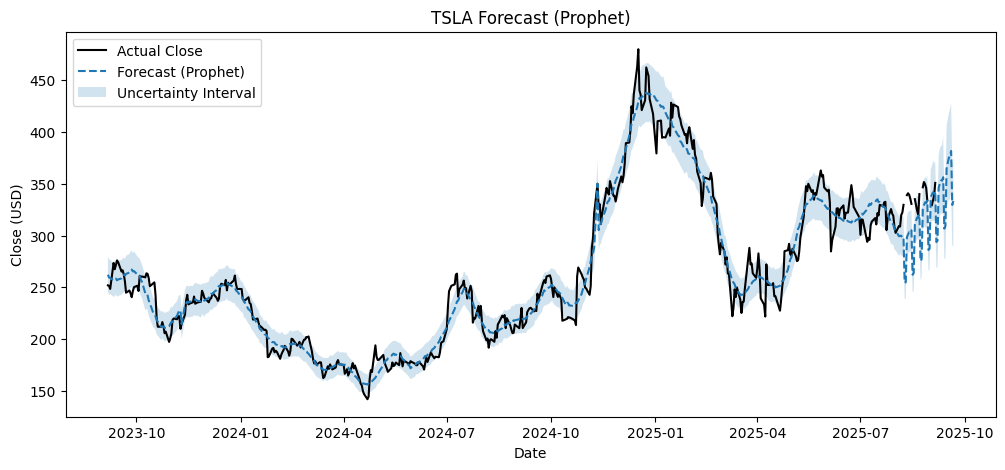

In [9]:
# 향후 30영업일 예측용 캘린더 생성 (거칠게 45일 확장 후 영업일 필터 없이 사용)
future = m.make_future_dataframe(periods=45, freq="D")  # D 기준
forecast = m.predict(future)

# 역변환 컬럼 추가
if use_log:
    forecast["yhat_real"] = np.expm1(forecast["yhat"])
    forecast["yhat_lower_real"] = np.expm1(forecast["yhat_lower"])
    forecast["yhat_upper_real"] = np.expm1(forecast["yhat_upper"])
else:
    forecast["yhat_real"] = forecast["yhat"]
    forecast["yhat_lower_real"] = forecast["yhat_lower"]
    forecast["yhat_upper_real"] = forecast["yhat_upper"]

# 전체 예측 시각화 (실제 Close 함께)
merged = df[["Close"]].merge(forecast.set_index("ds")[["yhat_real","yhat_lower_real","yhat_upper_real"]],
                             left_index=True, right_index=True, how="outer")

plt.plot(merged.index, merged["Close"], label="Actual Close", color="black")
plt.plot(merged.index, merged["yhat_real"], label="Forecast (Prophet)", linestyle="--")
plt.fill_between(merged.index,
                 merged["yhat_lower_real"],
                 merged["yhat_upper_real"],
                 alpha=0.2, label="Uncertainty Interval")
plt.title("TSLA Forecast (Prophet)")
plt.xlabel("Date"); plt.ylabel("Close (USD)")
plt.legend(); plt.show()

# Prophet 기본 플롯(옵션)
# from prophet.plot import plot_plotly, plot_components_plotly
# plot_plotly(m, forecast); plot_components_plotly(m, forecast)
